# Harmonics and Fourier Analysis of a Square Wave

A square wave is composed of a fundamental frequency ($f_{0}$) and a series of harmonics at higher frequencies. The harmonics have frequencies that are odd integer multiples of the fundamental frequency (i.e., $f = nf_{0}$ for n = 3, 5, 7,...). The amplitudes of the harmonics obey the following relation:

$$
\frac{|c_k(f)|}{|c_k(f_{0})|} \propto \left( \frac{f}{f_{0}} \right)^{\alpha}
$$


where $c_k(f)$ are the Fourier coefficients of the harmonics of the square wave and $\alpha$ is a constant. $c_k(f_{0})$ is the Fourier coefficient of the fundamental frequency.

The goal of this analysis is to:

1. Compute the Fourier transform of a given square wave signal ($y(t)$) to determine the amplitude spectrum.
2. Identify the locations of the harmonics and extract the fundamental frequency ($f_{0}$).
3. Fit a curve to the amplitudes of the harmonics to determine the exponent ($\alpha$), which characterizes the spectral decay.
4. Visualize the amplitude spectrum in a log–log plot, showing both the raw spectrum and the fitted power-law curve.

This approach allows me to quantify the harmonic content of the square wave and understand the relationship between frequency and amplitude in the frequency domain.

## Imports

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import scipy.linalg
from scipy.signal import find_peaks

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

## Given Square Wave

I start with a synthetic square wave signal that will be used for Fourier analysis. The square wave is characterized by a fundamental frequency ($f_0$) and a number of full cycles.

Key points:

* `f0`: The fundamental frequency of the square wave (in Hz). This determines how many oscillations occur per second.
* `alpha`: The slope of the harmonic amplitude decay on a log-log scale. For an ideal square wave, it is theoretically $-1$.
* `n`: The number of points used to sample the square wave. Higher `n` gives a smoother curve.
* `n_cycles`: Number of complete square wave cycles to generate.
* `t`: Time array, evenly spaced from 0 to the total time `t_end`.
* `y`: The square wave itself generated using `scipy.signal.square`


Reference (used to generate square wave): f0 = 2.25, alpha = -1


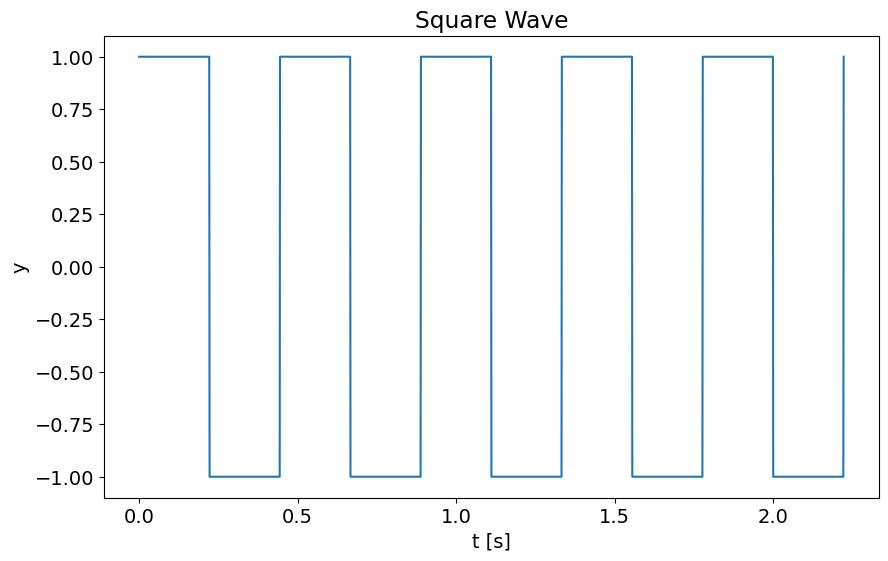

In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def load_square_wave(f0=2.25, n=2001, alpha=-1, n_cycles=5):

    print(f"Reference (used to generate square wave): f0 = {f0}, alpha = {alpha}")

    # Compute period and time vector
    T = 1.0 / f0
    t_end = n_cycles * T
    t = np.linspace(0.0, t_end, n)

    # Generate square wave in [-1, 1] and scale to [0, 1]
    y = signal.square(2 * np.pi * f0 * t)

    return t, y

# Generate square wave
t, y = load_square_wave()

# Plot
plt.plot(t, y)
plt.xlabel("t [s]")
plt.ylabel("y")
plt.title("Square Wave")
plt.show()


## Estimating ($f_0$) and ($\alpha$) from the Square Wave

In this section, I analyze the synthetic square wave signal to extract its fundamental frequency ($f_0$) and the decay of harmonic amplitudes ($\alpha$).

1. **Fourier Transform**:

   I compute the Fourier transform of the square wave using `np.fft.rfft`. This converts the time-domain signal into its frequency-domain representation, giving us the complex Fourier coefficients ($c_k$) for each frequency. The magnitude of these coefficients represents the amplitude of each frequency component.
   

2. **Identifying Harmonics**:

   Using `scipy.signal.find_peaks`, I locate the peaks in the amplitude spectrum. Each peak corresponds to a harmonic of the fundamental frequency. The first peak corresponds to $f_0$, and the subsequent peaks occur at odd multiples of $f_0$ (i.e., $f = nf_{0}$ for n = 3, 5, 7,...).
   

3. **Estimating $\alpha$**

    The amplitudes of the harmonics decay roughly as a power law:

    $$
    \frac{|c_k(f)|}{|c_k(f_{0})|} \propto \left( \frac{f}{f_{0}} \right)^{\alpha}
    $$

    Taking logarithms of both the frequency ratios and amplitude ratios gives a linear relationship:

    $$
    \log \frac{|c_k(f)|}{|c_k(f_{0})|} = \alpha \, \log \frac{f}{f_{0}} + \log(A)
    $$

    Here $\alpha$ is the slope of the line (decay rate of the harmonics), and $\log(A)$ is the intercept (constant of proportionality).

    We estimate these parameters using least squares fitting (`scipy.linalg.lstsq`) on the log-transformed ratios.



4. **Plotting the Spectrum**:
   I plot the amplitude spectrum on a log-log scale, marking the harmonic peaks and overlaying the fitted decay curve. This visualizes both the fundamental frequency and the power-law decay of harmonic amplitudes.

**Note:** For the generated square wave, the theoretical $\alpha$ is $-1$. The measured value may be slightly different due to the discrete sampling and number of points, but it should be very close. The square wave itself is independent of $\alpha$; this parameter is only relevant for analyzing the harmonic structure.


In [4]:
def model_fit(log_freq_ratio, log_amplitude_ratio):
    """
    fitting model that looks like:
    log_amplitude_ratio = alpha*log_freq_ratio + ln(A)
    where A is the constant of proportionality
    """
    N = len(log_freq_ratio)
    A = np.zeros((N, 2)) #design matrix
    for i in [0, 1]:
        A[:, i] = log_freq_ratio**i
        res = scipy.linalg.lstsq(A, log_amplitude_ratio)
        param = res[0]
    return param

In [5]:
def find_f0_and_param(ck, peaks):
    
    #find frequencies of peaks
    peak_frequencies = freq[peaks]
    
    #fundamental frequency f0 is the first peak
    f0 = peak_frequencies[0]

    #fit the frequencies to the model and return parameters
    log_freq_ratio = np.log(peak_frequencies / f0)
    log_amplitude_ratio = np.log(np.abs(ck[peaks]) / np.abs(ck[peaks[0]]))
    param = model_fit(log_freq_ratio, log_amplitude_ratio) 
    
    return f0, param

In [6]:
def plots1(ck, freq, f0, param, peaks):

    xgrid = np.linspace(1, 200, 200)
    curve_fit = np.abs(ck[peaks[0]])*np.exp(param[0])*(xgrid**param[1])
    
    plt.loglog(freq/f0, np.abs(ck), label='Amplitude Spectrum')
    plt.scatter(freq[peaks]/f0, np.abs(ck[peaks]), color = "orange", marker = "o", label = "Harmonics")
    plt.plot(xgrid, curve_fit, color = "green", linestyle = "--", label = "Curve Fit")
    
    plt.xlabel("frequency/f0")
    plt.ylabel("Amplitude spectrum")
    plt.title("Amplitude Spectrum of Square Wave")
    plt.legend()


Reference (used to generate square wave): f0 = 2.25, alpha = -1
Estimated from signal: f0 = 2.2489, alpha = -0.9991


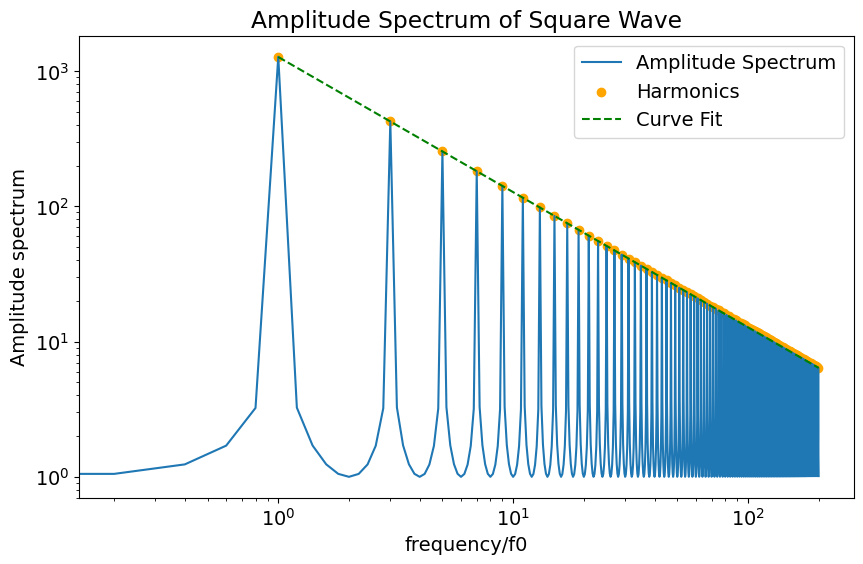

In [7]:
t, y = load_square_wave()

#perform fourier transform
dt = t[1] - t[0]
freq = np.fft.rfftfreq(len(y), dt)
ck = np.fft.rfft(y)

#find peaks
peaks, _ = find_peaks(np.abs(ck))
    
f0, param = find_f0_and_param(ck, peaks)
alpha = param[1] #since p0 would be ln(A)

print(f"Estimated from signal: f0 = {f0:.4f}, alpha = {alpha:.4f}")

plots1(ck, freq, f0, param, peaks)